### Book reviews classification using BERT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
source_folder = '/content/drive/My Drive/DL/DL_Final_Project/source'
destination_folder = '/content/drive/My Drive/DL/DL_Final_Project/destination'

In [ ]:
!pip install transformers
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 69.0 MB/s 
     |████████████████████████████████| 101 kB 14.1 MB/s 
     |████████████████████████████████| 6.6 MB 46.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 7.9 MB/s 
     |████████████████████████████████| 831.4 MB 2.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn import metrics

# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Model parameter
MAX_SEQ_LEN = 250       #363 95% - between 128 to 512
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('class', label_field), ('text', text_field)]

# TabularDataset
train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)


# Iterators
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=32, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors


#### Model

In [ ]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

#### Training

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):
    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),      #binary cross entropy loss function
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, texts), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            texts = texts.type(torch.LongTensor)  
            texts = texts.to(device)
            output = model(texts, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, texts), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        texts = texts.type(torch.LongTensor)  
                        texts = texts.to(device)
                        output = model(texts, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
%%time
train(model=model, optimizer=optimizer)

Epoch [1/5], Step [350/3505], Train Loss: 0.6330, Valid Loss: 0.6578
Model saved to ==> /content/drive/My Drive/DL/DL_Final_Project/destination/model.pt
Model saved to ==> /content/drive/My Drive/DL/DL_Final_Project/destination/metrics.pt
Epoch [1/5], Step [700/3505], Train Loss: 0.5940, Valid Loss: 0.7498
Epoch [2/5], Step [1050/3505], Train Loss: 0.5384, Valid Loss: 0.5999
Model saved to ==> /content/drive/My Drive/DL/DL_Final_Project/destination/model.pt
Model saved to ==> /content/drive/My Drive/DL/DL_Final_Project/destination/metrics.pt
Epoch [2/5], Step [1400/3505], Train Loss: 0.5094, Valid Loss: 0.7008
Epoch [3/5], Step [1750/3505], Train Loss: 0.4335, Valid Loss: 0.6778
Epoch [3/5], Step [2100/3505], Train Loss: 0.4094, Valid Loss: 0.6155
Epoch [4/5], Step [2450/3505], Train Loss: 0.3284, Valid Loss: 0.7350
Epoch [4/5], Step [2800/3505], Train Loss: 0.2955, Valid Loss: 0.6387
Epoch [5/5], Step [3150/3505], Train Loss: 0.2426, Valid Loss: 0.9210
Epoch [5/5], Step [3500/3505], T

Model loaded from <== /content/drive/My Drive/DL/DL_Final_Project/destination/metrics.pt


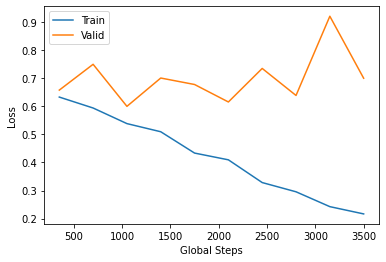

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

#### Evaluation

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, texts), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                texts = texts.type(torch.LongTensor)  
                texts = texts.to(device)
                output = model(texts, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['SPOILER', 'NON-SPOILER'])
    ax.yaxis.set_ticklabels(['SPOILER', 'NON-SPOILER'])
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    print("AUC=", metrics.auc(fpr, tpr))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/My Drive/DL/DL_Final_Project/destination/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.6876    0.8373    0.7551      1020
           0     0.7559    0.5698    0.6498       902

    accuracy                         0.7118      1922
   macro avg     0.7217    0.7035    0.7024      1922
weighted avg     0.7196    0.7118    0.7057      1922

AUC= 0.7035498456588843


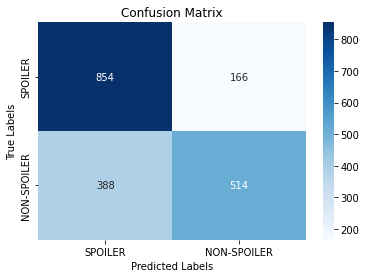

In [ ]:
best_model = BERT().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=2e-5)

load_checkpoint(destination_folder + '/model.pt', best_model)
evaluate(best_model, test_iter)